# Setup

In [97]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

from matplotlib.backends.backend_pdf import PdfPages


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

df_counties = get_complete_county_data()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

df_goog_mob_state = get_goog_mvmt_state()

## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True


State Testing Data Last Observation:  20200719


In [99]:
list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_fore_allstates = pd.read_pickle(latest_file)


./output/df_fore_allstates_20200720.pkl


In [100]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)

./output/allstate_model_dicts_20200720.pkl


# Development

In [101]:
state = 'NY'
model_dict = allstate_model_dicts[state]
df_agg = df_fore_allstates[state].unstack('metric')
scenario_name = 'No Change in Future Rᵗ Until 20% Hospital Capacity Trigger'
chart_title = "{1} Scenario".format(
        model_dict['region_name'], scenario_name)
param_str = param_str_maker(model_dict)


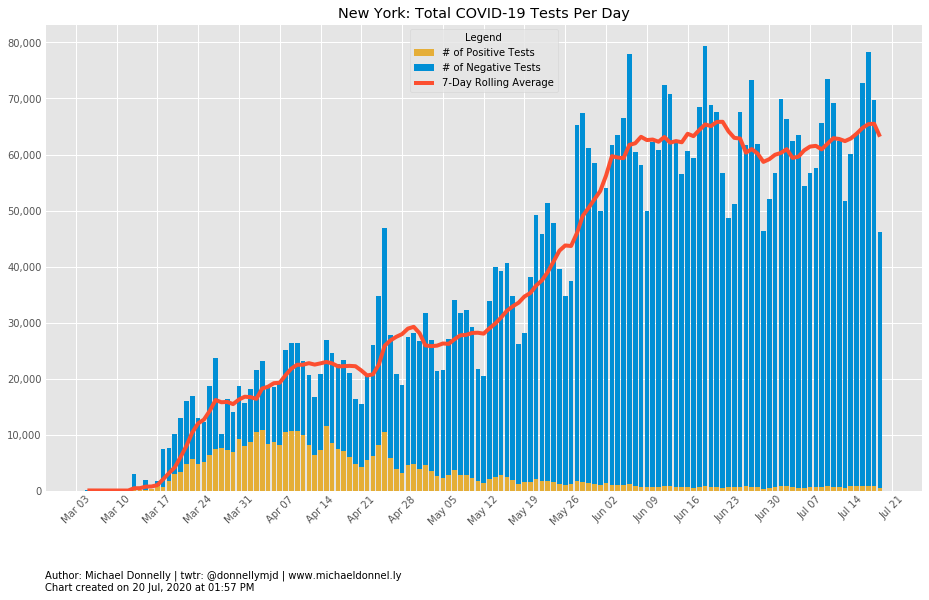

In [103]:
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
ch_totaltests(model_dict)


In [83]:
from coronita_chart_helper import *
reset_output()
output_notebook()

df_chart = df_fore_allstates.stack().unstack('metric')['exposed_daily'].unstack(1)
names_sub = df_chart.columns.to_list()
data = df_chart.reset_index()
source = ColumnDataSource(data)
# create CDS for filtered sources
filt_data1 = data[['dt','NY']].rename(columns={'NY':'cases'})
src2 = ColumnDataSource(filt_data1)
filt_data2 = data[['dt','CA']].rename(columns={'CA':'cases'})
src3 = ColumnDataSource(filt_data2)

hover_tool = HoverTool(tooltips=[
            ('Cases', '@cases'),
            ('Date', '@dt')],
            formatters={'dt': 'datetime'}
        )

p1 = figure(x_axis_type='datetime',
           tools=[hover_tool],title='Model-Estimated New COVID-19 Infections Per Day',
            y_range=Range1d(start=0, end=filt_data1.cases.max()+50),
            sizing_mode="scale_width", plot_height=400
           )


p1.line(x='dt',y='cases', source=src2, legend_label="State 1 (Left Axis)", line_color='blue',
        line_width=3,line_alpha=.8)

#set the second y-axis and use that with our second line
p1.extra_y_ranges = {"y2": Range1d(start=0, end=filt_data2.cases.max()+50)}
p1.add_layout(LinearAxis(y_range_name="y2",
                        formatter=NumeralTickFormatter(format="0%")
                        ),
              'right')
p1.line(x='dt',y='cases', source=src3, legend_label="State 2 (Right Axis)", line_color='orange',
        line_width=3,line_alpha=.8,y_range_name="y2")

p1.yaxis[0].axis_label = 'NY'
p1.yaxis[1].axis_label = 'CA'
p1.yaxis.formatter = NumeralTickFormatter(format="0a")
p1.legend.location = "top_left"
p1.xaxis.axis_label = 'Date'
p1.xaxis.formatter=DatetimeTickFormatter(days='%b %d',
months='%b %d',
)
#this javascript snippet is the callback when either select is changed

# y_range.end = parseInt(y[y.length - 1]+50);
code="""
var c = cb_obj.value;
ax.axis_label = c;
var y = s1.data[c];
const y_nonan = y.filter(function (value) {
    return !Number.isNaN(value);
});
var y_max = Math.max(...y_nonan);
s2.data['cases'] = y;
y_range.start = 0;
y_range.end = parseInt(y_max);
s2.change.emit();
"""
callback1 = CustomJS(args=dict(s1=source,
                               s2=src2,
                               y_range=p1.y_range,
                               ax=p1.yaxis[0],
                               leg=p1.legend
                              ), code=code)
callback2 = CustomJS(args=dict(s1=source,
                               s2=src3,
                               y_range=p1.extra_y_ranges['y2'],
                               ax=p1.yaxis[1],
                               leg=p1.legend
                              ), code=code)

select1 = Select(title="State 1:", value='NY', options=names_sub)
select1.js_on_change('value', callback1)
select2 = Select(title="State 2:", value='CA', options=names_sub)
select2.js_on_change('value', callback2)

btn = Button(label='Update')

p1 = bk_legend(p1)
p1 = add_bokeh_footnote(p1)
p1.legend.orientation = 'horizontal'
p1.add_layout(p1.legend[0], 'above')


output_notebook(); curdoc().theme = bk_theme
layout = column(row(select1,select2), row(p1), sizing_mode='scale_width')
show(layout)
output_file('./output/compare.html'); curdoc().theme = bk_theme
save(layout)

with open('./output/compare.html', 'r') as fin:
    data = fin.read().splitlines(True)
with open('../COVIDoutlook/_includes/compare.html', 'w') as fout:
    fout.writelines(data[5:])

Loading BokehJS ...

Loading BokehJS ...

# COVIDoutlook

## US Overview

In [88]:
model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)
df_fore_us = df_fore_allstates.sum(axis=1, skipna=True).unstack('metric').dropna(how='all')
tot_pop = df_fore_us[['susceptible', 'deaths', 'exposed', 'hospitalized', 'infectious', 'recovered']].sum(axis=1)
max_tot_pop = tot_pop.max()
df_fore_us.loc[tot_pop<max_tot_pop, 'susceptible'] = df_fore_us['susceptible'] + (max_tot_pop - tot_pop)

df_agg = df_fore_us
scenario_name = 'No Change in Future Rᵗ Until 20% Hospital Capacity Trigger'
chart_title = "" #"{1} Scenario".format(model_dict['region_name'], scenario_name)
param_str = param_str_maker(model_dict)


In [90]:
from coronita_bokeh_helper import *
reset_output()
output_notebook()

p_cases = bk_positivetests(model_dict)
# p_cases.x_range = Range1d(pd.Timestamp('2020-03-01'), model_dict['df_hist'].last_valid_index())
p_cases = bk_overview_layout(p_cases, 2)

p_tests = bk_totaltests(model_dict)
# p_tests.x_range = p_cases.x_range
p_tests = bk_overview_layout(p_tests, 2)

p_positivity = bk_postestshare(model_dict)
# p_positivity.x_range = p_cases.x_range
p_positivity = bk_overview_layout(p_positivity)

p_rt_conf = bk_rt_confid(model_dict, simplify=False)
# p_rt_conf.x_range = p_cases.x_range
p_rt_conf = bk_overview_layout(p_rt_conf)

p_googmvmt = bk_googmvmt(model_dict)
# p_googmvmt.x_range = p_cases.x_range
p_googmvmt = bk_overview_layout(p_googmvmt)

p_det_rt = bk_detection_rt(df_agg, model_dict)
# p_det_rt.x_range = p_cases.x_range
p_det_rt = bk_overview_layout(p_det_rt)

p_pop_share = bk_population_share(df_agg, model_dict, param_str, chart_title)
# p_pop_share.x_range = p_cases.x_range
p_pop_share = bk_overview_layout(p_pop_share)

curdoc().theme = bk_theme
r1 = [p_cases, p_tests, p_positivity, p_rt_conf,p_googmvmt,
      p_det_rt, p_pop_share]

script, div = components(r1)

template = Template('''<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Bokeh Scatter Plots</title>
        {{ resources }}
        {{ script }}
        
        <link rel="stylesheet" href="https://www.w3schools.com/w3css/4/w3.css">
    </head>
    <body>
    <div class="w3-row-padding">
        <div class="w3-half">
            {{ div[0] }}
        </div>

        <div class="w3-half">
            {{ div[1] }}
        </div>
    </div>
    {% for chart in div[2:] %}
        <div class="w3-container">
            {{ chart }}
        </div>
    {% endfor %}
    </body>
</html>
''')

resources = INLINE.render()

filename = 'embed_multiple.html'

html = template.render(resources=resources,
                       script=script,
                       div=div)

with io.open('../COVIDoutlook/us_overview.html', mode='w', encoding='utf-8') as f:
    f.write(html)
    

Loading BokehJS ...

## Reproduction Rate Page

In [91]:
from coronita_bokeh_helper import *
reset_output()
output_notebook()
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()
l_rt_conf = []

model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)
l_rt_conf.append(bk_rt_confid(model_dict, True))
l_rt_conf[-1] = bk_overview_layout(l_rt_conf[-1], 1)

for region in df_st_testing_fmt['date'].columns:
    try:
        model_dict = make_model_dict_state(region, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150)
        
        this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[region])
        this_reg_df_wavg = pd.DataFrame(
            model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[region])
        
        l_rt_conf.append(bk_rt_confid(model_dict, simplify=True))
        l_rt_conf[-1] = bk_repro_layout(l_rt_conf[-1], 2)
#         l_rt_conf[-1].x_range = l_rt_conf[0].x_range
        
        df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
        df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs,this_reg_df_wavg], axis=1)
    except:
        print('Cannot forecast {}'.format(region))

df_rts_allregs.index.names = ['dt','metric']


Loading BokehJS ...

Cannot forecast AS
Cannot forecast GU
Cannot forecast MP
Cannot forecast PR
Cannot forecast VI


In [96]:
curdoc().theme = bk_theme
script, div = components(l_rt_conf)

template = Template('''<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Bokeh Scatter Plots</title>
        {{ resources }}
        {{ script }}
        
        <link rel="stylesheet" href="https://www.w3schools.com/w3css/4/w3.css">

    </head>
    <body>
    <div class="w3-row-padding">
        <div class="w3-container">
            {{ div[0] }}
        </div>
    {% for chart in div[1:] %}
        <div class="w3-third">
            {{ chart }}
        </div>
    {% endfor %}
    </div>
    </body>
</html>
''')

resources = INLINE.render()

html = template.render(resources=resources,
                       script=script,
                       div=div)

with io.open('../COVIDoutlook/rts.html', mode='w', encoding='utf-8') as f:
    f.write(html)
